In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score,roc_curve, brier_score_loss, precision_recall_curve, average_precision_score
from sklearn.calibration import calibration_curve
from tensorflow.keras import layers, models
import torchaudio
from torchaudio import transforms
import torch
import denoiser

In [37]:
parkinsons_data = pd.read_csv('parkinsons.csv')

In [38]:
parkinsons_data.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [39]:
parkinsons_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

In [40]:
parkinsons_data.isnull().sum()

name                0
MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64

In [41]:
parkinsons_data.shape

(195, 24)

In [42]:
parkinsons_data['status'].value_counts()

status
1    147
0     48
Name: count, dtype: int64

In [43]:
parkinsons_data.drop(columns=["name"]).groupby('status').mean()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
status,,,,,,,,,,,,,,,,,,,,,
0,181.937771,223.636750,145.207292,0.003866,0.000023,0.001925,0.002056,0.005776,0.017615,0.162958,...,0.013305,0.028511,0.011483,24.678750,0.442552,0.695716,-6.759264,0.160292,2.154491,0.123017
1,145.180762,188.441463,106.893558,0.006989,0.000051,0.003757,0.003900,0.011273,0.033658,0.321204,...,0.027600,0.053027,0.029211,20.974048,0.516816,0.725408,-5.333420,0.248133,2.456058,0.233828


In [44]:
X = parkinsons_data.drop(columns=["name","status"], axis =1)

In [45]:
Y = parkinsons_data["status"]

In [46]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

In [47]:
scaler = StandardScaler()

In [48]:
scaler.fit(X_train)

,copy,True
,with_mean,True
,with_std,True


In [49]:
X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

In [50]:
model = svm.SVC(kernel='linear')

In [51]:
model.fit(X_train, Y_train)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [52]:
X_train_results = model.predict(X_train)
Training_accuracy = accuracy_score(X_train_results,Y_train)
print("Accuracy : ",Training_accuracy*100 , "%")

Accuracy :  88.46153846153845 %


In [53]:
X_test_results = model.predict(X_test)
Test_accuracy = accuracy_score(X_test_results,Y_test)
print("Accuracy : ",Test_accuracy*100 , "%")

Accuracy :  87.17948717948718 %


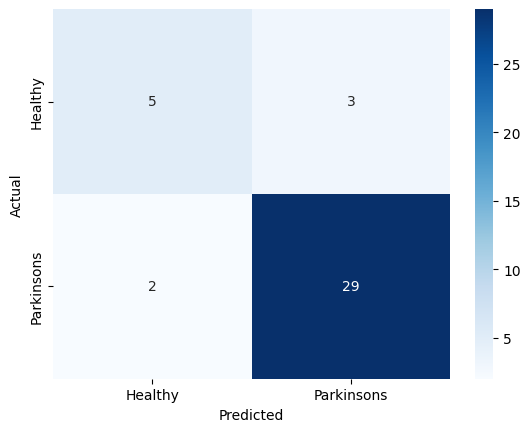

              precision    recall  f1-score   support

           0       0.71      0.62      0.67         8
           1       0.91      0.94      0.92        31

    accuracy                           0.87        39
   macro avg       0.81      0.78      0.79        39
weighted avg       0.87      0.87      0.87        39



In [54]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

cm = confusion_matrix(Y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthy', 'Parkinsons'],
            yticklabels=['Healthy', 'Parkinsons'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report
print(classification_report(Y_test, y_pred))

In [ ]:
NNmodel = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')   # binary classification
])

NNmodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

c:\Users\ayush\OneDrive\Desktop\Evrything\Workspace\Pandas\venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [56]:
history = NNmodel.fit(X_train, Y_train,
                    validation_data=(X_test, Y_test),
                    epochs=50,
                    batch_size=16,
                    verbose=1)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.5449 - loss: 0.6907 - val_accuracy: 0.7692 - val_loss: 0.6049
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5833 - loss: 0.6280 - val_accuracy: 0.8718 - val_loss: 0.5310
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7372 - loss: 0.5400 - val_accuracy: 0.8718 - val_loss: 0.4813
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7692 - loss: 0.4645 - val_accuracy: 0.8462 - val_loss: 0.4444
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7885 - loss: 0.4407 - val_accuracy: 0.8718 - val_loss: 0.4161
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8333 - loss: 0.4024 - val_accuracy: 0.8974 - val_loss: 0.3973
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8269 - loss: 0.3856 - val_accuracy: 0.8974 - val_loss: 0.3783
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8333 - loss: 0.3612 - val_accuracy: 0.8974 - v

In [57]:
loss, acc = NNmodel.evaluate(X_test, Y_test)
print(f"Test Accuracy: {acc:.2f}")
NNy_pred = (NNmodel.predict(X_test) > 0.29).astype(int)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7949 - loss: 0.3102
Test Accuracy: 0.79
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


n_samples: 39
min prob: 0
max prob: 1
unique probs: (2,)
status
1    31
0     8
Name: count, dtype: int64


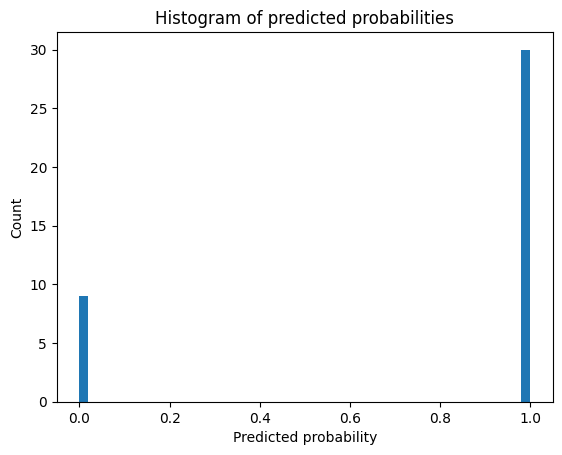

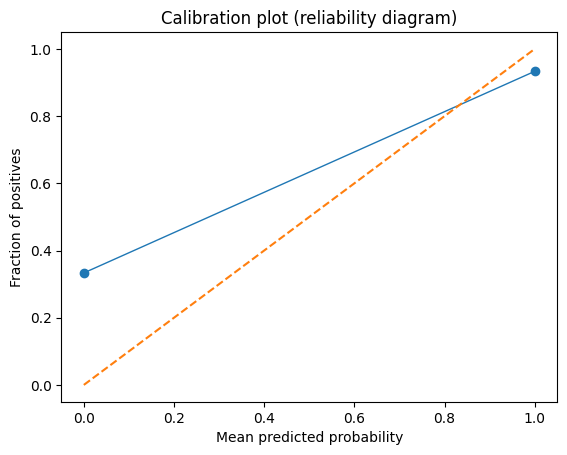

Brier score: 0.1282051282051282


In [58]:
print("n_samples:", len(NNy_pred))
print("min prob:", NNy_pred.min())
print("max prob:", NNy_pred.max())
print("unique probs:", np.unique(np.round(NNy_pred, 3)).shape)  # how many distinct values

# 2. Class counts
import pandas as pd
print(pd.Series(Y_test).value_counts())

# 3. Histogram of probabilities
plt.hist(NNy_pred, bins=50)
plt.xlabel("Predicted probability")
plt.ylabel("Count")
plt.title("Histogram of predicted probabilities")
plt.show()

# 4. Calibration curve + Brier score
prob_true, prob_pred = calibration_curve(Y_test, NNy_pred, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', linewidth=1)
plt.plot([0,1],[0,1], '--')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration plot (reliability diagram)')
plt.show()

print("Brier score:", brier_score_loss(Y_test, NNy_pred))

In [59]:
NNy_probs = NNmodel.predict(X_test).ravel()  # gives probabilities between 0 and 1

# Then use:
fpr, tpr, thresholds = roc_curve(Y_test, NNy_probs)
auc = roc_auc_score(Y_test, NNy_probs)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


AUC: 0.935


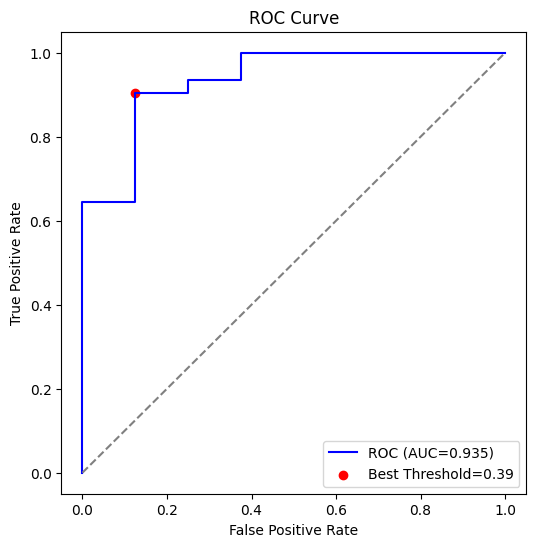

Optimal threshold by Youden’s J: 0.389


In [60]:
fpr, tpr, thresholds = roc_curve(Y_test, NNy_probs)
auc = roc_auc_score(Y_test, NNy_probs)
print(f"AUC: {auc:.3f}")

# Plot ROC
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC (AUC={auc:.3f})')
plt.plot([0,1],[0,1],'--',color='gray')

# Find optimal threshold by Youden’s J
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label=f'Best Threshold={best_thresh:.2f}')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print(f"Optimal threshold by Youden’s J: {best_thresh:.3f}")

In [61]:
y_pred_029 = (NNy_probs >= 0.29).astype(int)

print("Confusion Matrix:\n", confusion_matrix(Y_test, y_pred_029))
print("\nClassification Report:\n", classification_report(Y_test, y_pred_029, digits=3))

Confusion Matrix:
 [[ 6  2]
 [ 3 28]]

Classification Report:
               precision    recall  f1-score   support

           0      0.667     0.750     0.706         8
           1      0.933     0.903     0.918        31

    accuracy                          0.872        39
   macro avg      0.800     0.827     0.812        39
weighted avg      0.879     0.872     0.875        39



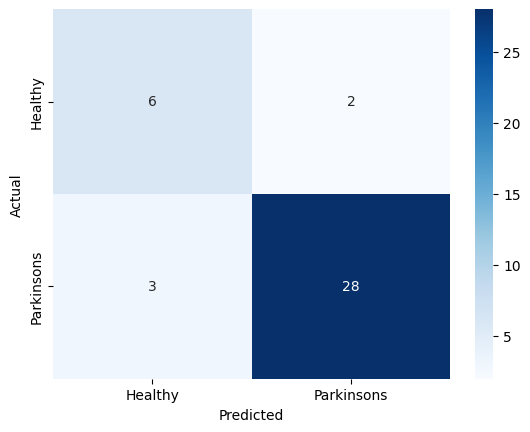

              precision    recall  f1-score   support

           0       0.67      0.75      0.71         8
           1       0.93      0.90      0.92        31

    accuracy                           0.87        39
   macro avg       0.80      0.83      0.81        39
weighted avg       0.88      0.87      0.87        39



In [62]:


cm = confusion_matrix(Y_test, y_pred_029)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthy', 'Parkinsons'],
            yticklabels=['Healthy', 'Parkinsons'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report
print(classification_report(Y_test, y_pred_029))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Average Precision (AP): 0.982


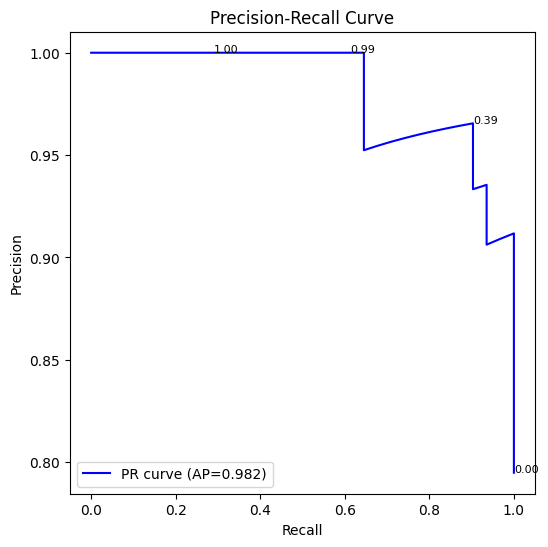

In [63]:
y_probs = NNmodel.predict(X_test).ravel()

# Precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(Y_test, y_probs)

# Average Precision Score (area under PR curve)
ap = average_precision_score(Y_test, y_probs)
print(f"Average Precision (AP): {ap:.3f}")

# Plot PR curve
plt.figure(figsize=(6,6))
plt.plot(recall, precision, color='blue', label=f'PR curve (AP={ap:.3f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

# Annotate thresholds on the curve (every 10th point for clarity)
for i in range(0, len(thresholds), 10):
    plt.text(recall[i], precision[i], f"{thresholds[i]:.2f}", fontsize=8)

plt.show()

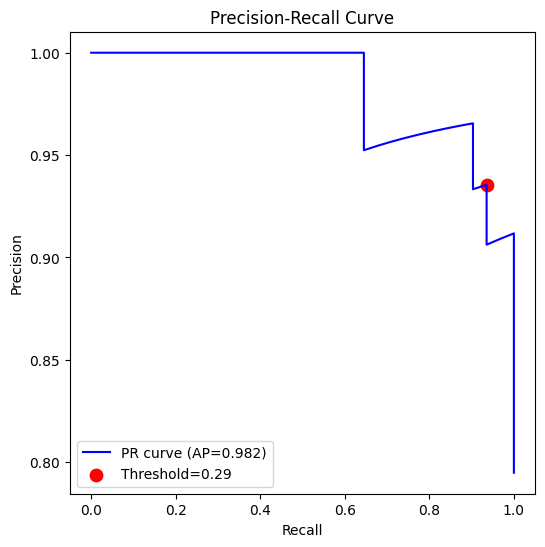

In [64]:
import numpy as np
thresh_val = 0.29
idx = (np.abs(thresholds - thresh_val)).argmin()

# Plot PR curve
plt.figure(figsize=(6,6))
plt.plot(recall, precision, color='blue', label=f'PR curve (AP={ap:.3f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")

# Mark the chosen threshold point
plt.scatter(recall[idx], precision[idx], color='red', s=80, label=f'Threshold={thresholds[idx]:.2f}')
plt.legend()
plt.show()

In [65]:
y_probs = NNmodel.predict(X_test).ravel()
y_pred_029 = (y_probs >= 0.29).astype(int)
acc = accuracy_score(Y_test, y_pred_029)
print(f"Test Accuracy: {acc:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Test Accuracy: 0.87


In [76]:
waveform, sr = torchaudio.load("DL1.wav")

mel_spectrogram = transforms.MelSpectrogram(
    sample_rate=sr,
    n_mels=128,
    f_max=8000
)(waveform)

mel_spectrogram_db1 = transforms.AmplitudeToDB()(mel_spectrogram)
print(mel_spectrogram_db1) 

tensor([[[-100., -100., -100.,  ..., -100., -100., -100.],
         [-100., -100., -100.,  ..., -100., -100., -100.],
         [-100., -100., -100.,  ..., -100., -100., -100.],
         ...,
         [-100., -100., -100.,  ..., -100., -100., -100.],
         [-100., -100., -100.,  ..., -100., -100., -100.],
         [-100., -100., -100.,  ..., -100., -100., -100.]],

        [[-100., -100., -100.,  ..., -100., -100., -100.],
         [-100., -100., -100.,  ..., -100., -100., -100.],
         [-100., -100., -100.,  ..., -100., -100., -100.],
         ...,
         [-100., -100., -100.,  ..., -100., -100., -100.],
         [-100., -100., -100.,  ..., -100., -100., -100.],
         [-100., -100., -100.,  ..., -100., -100., -100.]]])


c:\Users\ayush\OneDrive\Desktop\Evrything\Workspace\Pandas\venv\Lib\site-packages\torchaudio\_backend\utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
c:\Users\ayush\OneDrive\Desktop\Evrything\Workspace\Pandas\venv\Lib\site-packages\torchaudio\functional\functional.py:585: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


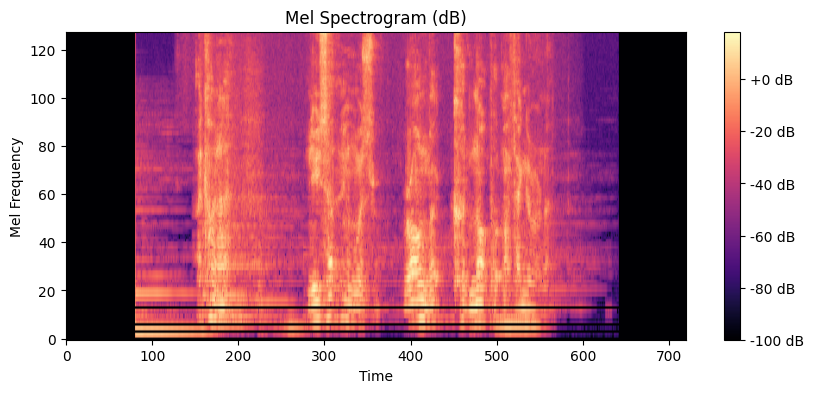

In [77]:
plt.figure(figsize=(10, 4))
plt.imshow(mel_spectrogram_db1[0].numpy(), aspect='auto', origin='lower', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectrogram (dB)")
plt.xlabel("Time")
plt.ylabel("Mel Frequency")
plt.show()


tensor([[[-100., -100., -100.,  ..., -100., -100., -100.],
         [-100., -100., -100.,  ..., -100., -100., -100.],
         [-100., -100., -100.,  ..., -100., -100., -100.],
         ...,
         [-100., -100., -100.,  ..., -100., -100., -100.],
         [-100., -100., -100.,  ..., -100., -100., -100.],
         [-100., -100., -100.,  ..., -100., -100., -100.]],

        [[-100., -100., -100.,  ..., -100., -100., -100.],
         [-100., -100., -100.,  ..., -100., -100., -100.],
         [-100., -100., -100.,  ..., -100., -100., -100.],
         ...,
         [-100., -100., -100.,  ..., -100., -100., -100.],
         [-100., -100., -100.,  ..., -100., -100., -100.],
         [-100., -100., -100.,  ..., -100., -100., -100.]]])


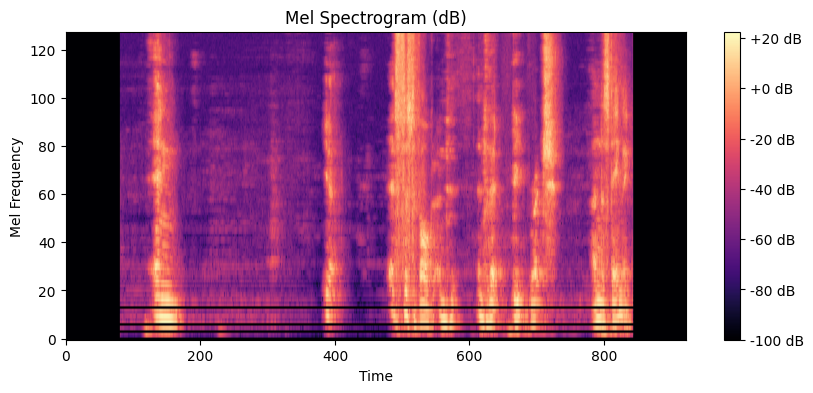

In [74]:
waveform, sr = torchaudio.load("DL10.wav")

mel_spectrogram = transforms.MelSpectrogram(
    sample_rate=sr,
    n_mels=128,
    f_max=8000
)(waveform)

mel_spectrogram_db = transforms.AmplitudeToDB()(mel_spectrogram)
print(mel_spectrogram_db) 

plt.figure(figsize=(10, 4))
plt.imshow(mel_spectrogram_db[0].numpy(), aspect='auto', origin='lower', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectrogram (dB)")
plt.xlabel("Time")
plt.ylabel("Mel Frequency")
plt.show()